In [1]:
import sys

# !{sys.executable} -m pip install xgboost
!{sys.executable} -m pip install dill

In [2]:
import numpy as np
import pandas as pd
import pandas
import scipy as sp
from sklearn.pipeline import Pipeline, make_pipeline, FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from numpy import int64, float64
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
trainFifa = pd.read_csv("./datasets/male_players (legacy).csv", low_memory=False)
ogFifa = trainFifa.copy()
fifa22 = pd.read_csv("./datasets/players_22.csv", low_memory=False)
pd.set_option("display.max_columns", None)

In [4]:
trainFifa.info(max_cols=500)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161583 entries, 0 to 161582
Data columns (total 110 columns):
 #    Column                          Non-Null Count   Dtype  
---   ------                          --------------   -----  
 0    player_id                       161583 non-null  int64  
 1    player_url                      161583 non-null  object 
 2    fifa_version                    161583 non-null  int64  
 3    fifa_update                     161583 non-null  int64  
 4    fifa_update_date                161583 non-null  object 
 5    short_name                      161583 non-null  object 
 6    long_name                       161583 non-null  object 
 7    player_positions                161583 non-null  object 
 8    overall                         161583 non-null  int64  
 9    potential                       161583 non-null  int64  
 10   value_eur                       159530 non-null  float64
 11   wage_eur                        159822 non-null  float64
 12   

In [5]:
trainFifa.head()

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url
0,158023,/player/158023/lionel-messi/150002,15,2,2014-09-18,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,100500000.0,550000.0,27,1987-06-24,169,67,53.0,La Liga,1.0,241.0,FC Barcelona,CF,10.0,NaN,2004-07-01,2018.0,52,Argentina,1369.0,CF,10.0,Left,3,4,5,Medium/Low,Normal (170-),Yes,NaN,"#Speedster, #Dribbler, #FK Specialist, #Acroba...","Finesse Shot, Speed Dribbler (AI), One Club Pl...",93.0,89.0,86.0,96.0,27.0,63.0,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,NaN,89+3,89+3,89+3,92+3,90+3,90+3,90+3,92+3,92+3,92+3,92+3,90+3,79+3,79+3,79+3,90+3,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3,15+3,https://cdn.sofifa.net/players/158/023/15_120.png
1,20801,/player/20801/c-ronaldo-dos-santos-aveiro/150002,15,2,2014-09-18,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,79000000.0,375000.0,29,1985-02-05,185,80,53.0,La Liga,1.0,243.0,Real Madrid CF,LW,7.0,NaN,2009-07-01,2018.0,38,Portugal,1354.0,LW,7.0,Right,4,5,5,High/Low,Normal (185+),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",93.0,93.0,81.0,91.0,32.0,79.0,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,NaN,91+1,91+1,91+1,89+3,91+1,91+1,91+1,89+3,89+3,89+3,89+3,87+3,77+3,77+3,77+3,87+3,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3,16+3,https://cdn.sofifa.net/players/020/801/15_120.png
2,9014,/player/9014/arjen-robben/150002,15,2,2014-09-18,A. Robben,Arjen Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,1984-01-23,180,80,19.0,Bundesliga,1.0,21.0,FC Bayern München,SUB,10.0,NaN,2009-08-28,2017.0,34,Netherlands,105035.0,RS,11.0,Left,2,4,5,High/Low,Normal (170-185),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Diver, Injury Prone, Avoids Using Weaker Foot,...",93.0,86.0,83.0,92.0,32.0,64.0,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,NaN,84+3,84+3,84+3,88+2,87+3,87+3,87+3,88+2,88+2,88+2,88+2,87+3,78+3,78+3,78+3,87+3,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3,14+3,https://cdn.sofifa.net/players/009/014/15_120.png
3,41236,/player/41236/zlatan-ibrahimovic/150002,15,2,2014-09-18,Z. Ibrahimović,Zlatan Ibrahimović,ST,90,90,52500000.0,275000.0,32,1981-10-03,195,95,16.0,Ligue 1,1.0,73.0,Paris Saint-Germain,ST,10.0,NaN,2012-07-01,2016.0,46,Sweden,1363.0,ST,10.0,Right,4,4,5,Medium/Low,Normal (185+),Yes,NaN,"#Poacher, #Aerial Threat, #Distance Shooter, #...","Power Free-Kick, Leadership, Flair, Long Shot ...",76.0,91.0,81.0,86.0,34.0,86.0,76,91,76,84

In [6]:
fifa22.info(max_cols=500)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 110 columns):
 #    Column                       Non-Null Count  Dtype  
---   ------                       --------------  -----  
 0    sofifa_id                    19239 non-null  int64  
 1    player_url                   19239 non-null  object 
 2    short_name                   19239 non-null  object 
 3    long_name                    19239 non-null  object 
 4    player_positions             19239 non-null  object 
 5    overall                      19239 non-null  int64  
 6    potential                    19239 non-null  int64  
 7    value_eur                    19165 non-null  float64
 8    wage_eur                     19178 non-null  float64
 9    age                          19239 non-null  int64  
 10   dob                          19239 non-null  object 
 11   height_cm                    19239 non-null  int64  
 12   weight_kg                    19239 non-null  int64  
 13  

In [7]:
fifa22.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,club_team_id,club_name,league_name,league_level,club_position,club_jersey_number,club_loaned_from,club_joined,club_contract_valid_until,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,"RW, ST, CF",93,93,78000000.0,320000.0,34,1987-06-24,170,72,73.0,Paris Saint-Germain,French Ligue 1,1.0,RW,30.0,NaN,2021-08-10,2023.0,52,Argentina,1369.0,RW,10.0,Left,4,4,5,Medium/Low,Unique,Yes,144300000.0,"#Dribbler, #Distance Shooter, #FK Specialist, ...","Finesse Shot, Long Shot Taker (AI), Playmaker ...",85.0,92.0,91.0,95.0,34.0,65.0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,NaN,89+3,89+3,89+3,92,93,93,93,92,93,93,93,91+2,87+3,87+3,87+3,91+2,66+3,64+3,64+3,64+3,66+3,61+3,50+3,50+3,50+3,61+3,19+3,https://cdn.sofifa.net/players/158/023/22_120.png,https://cdn.sofifa.net/teams/73/60.png,https://cdn.sofifa.net/flags/fr.png,https://cdn.sofifa.net/teams/1369/60.png,https://cdn.sofifa.net/flags/ar.png
1,188545,https://sofifa.com/player/188545/robert-lewand...,R. Lewandowski,Robert Lewandowski,ST,92,92,119500000.0,270000.0,32,1988-08-21,185,81,21.0,FC Bayern München,German 1. Bundesliga,1.0,ST,9.0,NaN,2014-07-01,2023.0,37,Poland,1353.0,RS,9.0,Right,4,4,5,High/Medium,Unique,Yes,197200000.0,"#Aerial Threat, #Distance Shooter, #Clinical F...","Solid Player, Finesse Shot, Outside Foot Shot,...",78.0,92.0,79.0,86.0,44.0,82.0,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,NaN,90+2,90+2,90+2,85,88,88,88,85,86+3,86+3,86+3,84+3,80+3,80+3,80+3,84+3,64+3,66+3,66+3,66+3,64+3,61+3,60+3,60+3,60+3,61+3,19+3,https://cdn.sofifa.net/players/188/545/22_120.png,https://cdn.sofifa.net/teams/21/60.png,https://cdn.sofifa.net/flags/de.png,https://cdn.sofifa.net/teams/1353/60.png,https://cdn.sofifa.net/flags/pl.png
2,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"ST, LW",91,91,45000000.0,270000.0,36,1985-02-05,187,83,11.0,Manchester United,English Premier League,1.0,ST,7.0,NaN,2021-08-27,2023.0,38,Portugal,1354.0,ST,7.0,Right,4,5,5,High/Low,Unique,Yes,83300000.0,"#Aerial Threat, #Dribbler, #Distance Shooter, ...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",87.0,94.0,80.0,88.0,34.0,75.0,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,NaN,90+1,90+1,90+1,88,89,89,89,88,86+3,86+3,86+3,86+3,78+3,78+3,78+3,86+3,63+3,59+3,59+3,59+3,63+3,60+3,53+3,53+3,53+3,60+3,20+3,https://cdn.sofifa.net/players/020/801/22_120.png,https://cdn.sofifa.net/teams/11/60.png,https://cdn.sofifa.net/flags/gb-eng.png,https://cdn.sofifa.net/teams/1354/60.png,https://cdn.sofifa.net/flags/pt.png


In [8]:
trainFifa["experience"] = datetime.now().year - pd.to_datetime(trainFifa["club_joined_date"]).dt.year
trainFifa["bmi"] = trainFifa["weight_kg"] / (trainFifa["height_cm"] / 100 ) ** 2
perfMetrics = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
trainFifa["avg_perf"] = trainFifa[perfMetrics].mean(axis=1)
trainFifa.head()

,player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url,experience,bmi,avg_perf
0,158023,/player/158023/lionel-messi/150002,15,2,2014-09-18,L. Messi,Lionel Andrés Messi Cuccittini,CF,93,95,100500000.0,550000.0,27,1987-06-24,169,67,53.0,La Liga,1.0,241.0,FC Barcelona,CF,10.0,NaN,2004-07-01,2018.0,52,Argentina,1369.0,CF,10.0,Left,3,4,5,Medium/Low,Normal (170-),Yes,NaN,"#Speedster, #Dribbler, #FK Specialist, #Acroba...","Finesse Shot, Speed Dribbler (AI), One Club Pl...",93.0,89.0,86.0,96.0,27.0,63.0,84,94,71,89,85,96,89,90,76,96,96,90,94,94,95,80,73,77,60,88,48,22,92,90,76,NaN,25,21,20,6,11,15,14,8,NaN,89+3,89+3,89+3,92+3,90+3,90+3,90+3,92+3,92+3,92+3,92+3,90+3,79+3,79+3,79+3,90+3,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3,15+3,https://cdn.sofifa.net/players/158/023/15_120.png,20.0,23.458562,75.666667
1,20801,/player/20801/c-ronaldo-dos-santos-aveiro/150002,15,2,2014-09-18,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,"LW, LM",92,92,79000000.0,375000.0,29,1985-02-05,185,80,53.0,La Liga,1.0,243.0,Real Madrid CF,LW,7.0,NaN,2009-07-01,2018.0,38,Portugal,1354.0,LW,7.0,Right,4,5,5,High/Low,Normal (185+),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Power Free-Kick, Flair, Long Shot Taker (AI), ...",93.0,93.0,81.0,91.0,32.0,79.0,83,95,86,82,87,93,88,79,72,92,91,94,93,90,63,94,94,89,79,93,63,24,91,81,85,NaN,22,31,23,7,11,15,14,11,NaN,91+1,91+1,91+1,89+3,91+1,91+1,91+1,89+3,89+3,89+3,89+3,87+3,77+3,77+3,77+3,87+3,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3,16+3,https://cdn.sofifa.net/players/020/801/15_120.png,15.0,23.374726,78.166667
2,9014,/player/9014/arjen-robben/150002,15,2,2014-09-18,A. Robben,Arjen Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,1984-01-23,180,80,19.0,Bundesliga,1.0,21.0,FC Bayern München,SUB,10.0,NaN,2009-08-28,2017.0,34,Netherlands,105035.0,RS,11.0,Left,2,4,5,High/Low,Normal (170-185),Yes,NaN,"#Speedster, #Dribbler, #Distance Shooter, #Acr...","Diver, Injury Prone, Avoids Using Weaker Foot,...",93.0,86.0,83.0,92.0,32.0,64.0,80,85,50,86,86,93,85,83,76,90,93,93,93,89,91,86,61,78,65,90,47,39,89,84,80,NaN,29,26,26,10,8,11,5,15,NaN,84+3,84+3,84+3,88+2,87+3,87+3,87+3,88+2,88+2,88+2,88+2,87+3,78+3,78+3,78+3,87+3,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3,14+3,https://cdn.sofifa.net/players/009/014/15_120.png,15.0,24.691358,75.000000
3,41236,/player/41236/zlatan-ibrahimovic/150002,15,2,2014-09-18,Z. Ibrahimović,Zlatan Ibrahimović,ST,90,90,52500000.0,275000.0,32,1981-10-03,195,95,16.0,Ligue 1,1.0,73.0,Paris Saint-Germain,ST,10.0,NaN,2012-07-01,2016.0,46,Sweden,1363.0,ST,10.0,Right,4,4,5,Medium/Low,Normal (185+),Yes,NaN,"#Poacher, #Aerial Threat, #Distance Shooter, 

In [9]:
quantsTrain = trainFifa.select_dtypes(exclude=["object"])
catsTrain = trainFifa[["overall", "work_rate", "preferred_foot", "body_type"]]
catsTrain.head()

,overall,work_rate,preferred_foot,body_type
0,93,Medium/Low,Left,Normal (170-)
1,92,High/Low,Right,Normal (185+)
2,90,High/Low,Left,Normal (170-185)
3,90,Medium/Low,Right,Normal (185+)
4,90,Medium/Medium,Right,Normal (185+)


In [10]:
from pandas.plotting import scatter_matrix

corr = quantsTrain.corr()
potFeatsIndex = corr.index[abs(corr["overall"]) > 0.3]
potFeats = corr["overall"].sort_values(ascending=False)
top = potFeats
potFeats = [feat for feat in zip(top, top.index)]
potFeats

# scatter_matrix(trainFifa[[*potFeats, "overall"]], figsize=(12, 8))

[(1.0, 'overall'),
 (0.8457533356097033, 'movement_reactions'),
 (0.8087492302877811, 'avg_perf'),
 (0.6953622503098226, 'potential'),
 (0.6833067218584632, 'mentality_composure'),
 (0.6811144954726577, 'passing'),
 (0.6113678580215334, 'wage_eur'),
 (0.6065748097944825, 'dribbling'),
 (0.5789135803096551, 'release_clause_eur'),
 (0.5668266013718758, 'value_eur'),
 (0.5132790658311635, 'physic'),
 (0.4997570921288494, 'attacking_short_passing'),
 (0.49328184062696273, 'mentality_vision'),
 (0.4852341254748284, 'international_reputation'),
 (0.4838083580077723, 'skill_long_passing'),
 (0.48249848666558115, 'shooting'),
 (0.4802971404171307, 'power_shot_power'),
 (0.4583902049253899, 'age'),
 (0.45701137501199873, 'skill_ball_control'),
 (0.41586287506002434, 'skill_curve'),
 (0.4090857750457564, 'power_long_shots'),
 (0.3983102760545, 'mentality_aggression'),
 (0.396833045696406, 'attacking_crossing'),
 (0.3872693425705684, 'skill_fk_accuracy'),
 (0.3850926901485894, 'goalkeeping_speed'

In [11]:
trainFifa = ogFifa
quantsTrain = trainFifa.select_dtypes(exclude=["object"])
corr = quantsTrain.corr()
potFeats = corr["overall"].sort_values(ascending=False)
top = potFeats[1:11]
potFeats = [feat for feat in zip(top, top.index)]
potFeats

[(0.8457533356097033, 'movement_reactions'),
 (0.6953622503098226, 'potential'),
 (0.6833067218584632, 'mentality_composure'),
 (0.6811144954726577, 'passing'),
 (0.6113678580215334, 'wage_eur'),
 (0.6065748097944825, 'dribbling'),
 (0.5789135803096551, 'release_clause_eur'),
 (0.5668266013718758, 'value_eur'),
 (0.5132790658311635, 'physic'),
 (0.4997570921288494, 'attacking_short_passing')]

In [12]:
potFeats = [feat for cor, feat in potFeats]
potFeats

['movement_reactions',
 'potential',
 'mentality_composure',
 'passing',
 'wage_eur',
 'dribbling',
 'release_clause_eur',
 'value_eur',
 'physic',
 'attacking_short_passing']

<Figure size 5000x1000 with 0 Axes>

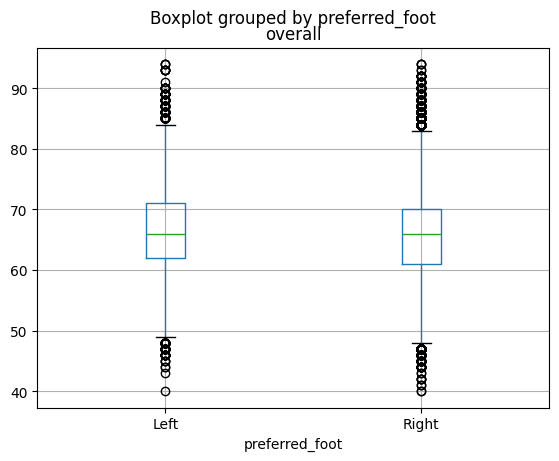

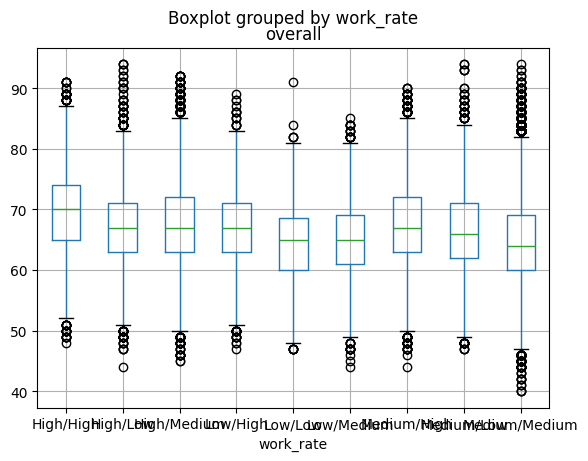

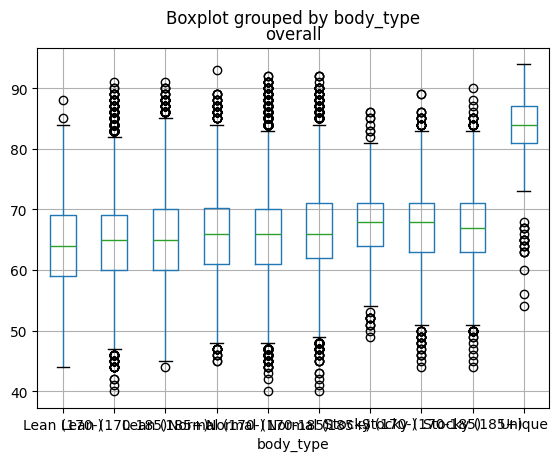

In [13]:
plt.figure(figsize=(50, 10))
catsTrain.boxplot(column=["overall"], by="preferred_foot")
catsTrain.boxplot(column=["overall"], by="work_rate")
catsTrain.boxplot(column=["overall"], by="body_type")
plt.show()

In [14]:
from numpy import floor

# chosenFeatures = ["release_clause_eur", "wage_eur", "age", "mentality_composure", "skill_ball_control",
#                   "movement_reactions", "attacking_short_passing", "passing", "dribbling"]

chosenCorFeatures = [*potFeats, "age", *perfMetrics[:-1]]
chosenCorFeatures.remove("potential")
chosenCorFeatures.remove("passing")
chosenCorFeatures.remove("dribbling")
chosenCorFeatures.remove("attacking_short_passing")


# trainFifa.drop(trainFifa[trainFifa["fifa_version"] == 22].index, inplace=True, axis=0)
trainFifa.dropna(thresh=floor(len(trainFifa) * 0.60), inplace=True, axis=1)



y_train = trainFifa[["overall"]].values.ravel()
X_train = trainFifa[chosenCorFeatures]
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(
    X_train, y_train, random_state=42, test_size=0.2
)

y_test = fifa22[["overall"]].values.ravel()
X_test = fifa22[chosenCorFeatures]
# X_test = fifa22.drop("overall", axis=1)
X_train_train.head()

,movement_reactions,mentality_composure,wage_eur,release_clause_eur,value_eur,physic,age,pace,shooting,passing,dribbling,defending
69722,72,71.0,40000.0,16000000.0,9000000.0,80.0,27,69.0,75.0,51.0,68.0,38.0
145131,76,72.0,45000.0,10900000.0,5500000.0,69.0,25,84.0,75.0,66.0,75.0,35.0
97854,47,44.0,5000.0,903000.0,475000.0,NaN,24,NaN,NaN,NaN,NaN,NaN
77978,64,68.0,2000.0,689000.0,475000.0,78.0,30,59.0,25.0,41.0,45.0,64.0
105151,80,76.0,60000.0,40700000.0,27000000.0,79.0,29,82.0,61.0,74.0,79.0,79.0


In [15]:
y_train_train[:5]

array([76, 74, 64, 66, 82])

In [16]:
maxIter = 20

def colAvg(X):
    return pd.DataFrame(X.mean(axis=1))


def avgName(functionTrans, featureNamesIn):
    return ["avg"]


avgPipe = make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(lambda X: pandas.DataFrame(X.mean(axis=1)), feature_names_out=lambda x, y: ["avg"]),
    )



quantPipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="median")),
        ("round",FunctionTransformer(np.round, feature_names_out="one-to-one")),
        # ("impute", IterativeImputer(max_iter=maxIter, random_state=42)),
        # ("scale", StandardScaler())
    ]
)

catPipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
    ]
)

dimPipe = make_pipeline(
    SimpleImputer(strategy="median"),
    # IterativeImputer(max_iter=maxIter, random_state=42),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    # FunctionTransformer(np.sqrt, feature_names_out="one-to-one"),
)

first = ColumnTransformer(
    [
        ("dim_eur", dimPipe, ["value_eur", "wage_eur", "release_clause_eur"]),
        ("avg_perf", avgPipe, perfMetrics),
        ("cat", catPipe, make_column_selector(dtype_include=[object])),
    ],
    remainder=quantPipe,
)
pipe = make_pipeline(first, MinMaxScaler())
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                              SimpleImputer(strategy='median')),
                                                             ('round',
                                                              FunctionTransformer(feature_names_out='one-to-one',
                                                                                  func=<function round at 0x799cad722570>))]),
                                   transformers=[('dim_eur',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionT...
                                                                                       func=<function <lambda> at 0x799caeb8b420>))]),
                                                  ['pace', 'shooting',
                                                   'passing', 'dribbling',
                                                   'defending', 'physic']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x799c5b114470>)])),
                ('minmaxscaler', MinMaxScaler())])

In [17]:
piped = pd.DataFrame(
    pipe.fit_transform(X_train_train),
    columns=pipe.get_feature_names_out(),
    index=X_train_train.index,
)
piped

,dim_eur__value_eur,dim_eur__wage_eur,dim_eur__release_clause_eur,avg_perf__avg,remainder__movement_reactions,remainder__mentality_composure,remainder__age
69722,0.747805,0.621783,0.703734,0.603448,0.684211,0.731183,0.289474
145131,0.707357,0.638496,0.667638,0.682759,0.736842,0.741935,0.236842
97854,0.506202,0.326723,0.433396,0.551724,0.355263,0.440860,0.210526
77978,0.506202,0.196707,0.407960,0.365517,0.578947,0.698925,0.368421
105151,0.838035,0.679316,0.791536,0.855172,0.789474,0.784946,0.342105
...,...,...,...,...,...,...,...
119879,0.514422,0.254240,0.395109,0.379310,0.526316,0.430108,0.184211
103694,0.348935,0.091075,0.219625,0.551724,0.447368,0.516129,0.210526
131932,0.600645,0.295060,0.521321,0.631034,0.657895,0.602151,0.236842
146867,0.632101,0.516151,0.575685,0.662069,0.684211,0.709677,0.263158


In [18]:
def tests(name, preds, actuals):
    rmse = root_mean_squared_error(preds, actuals)
    mae = mean_absolute_error(preds, actuals)
    r2s = r2_score(preds, actuals)
    print(f"{name}:\nRMSE: {rmse}\nMAE: {mae}\nR2S: {r2s}\n")

In [19]:
from sklearn.linear_model import LinearRegression

linPipe = Pipeline([("preprocessing", pipe), ("linear", LinearRegression())])
linPipe.fit(X_train_train, y_train_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                               SimpleImputer(strategy='median')),
                                                                              ('round',
                                                                               FunctionTransformer(feature_names_out='one-to-one',
                                                                                                   func=<function round at 0x799cad722570>))]),
                                                    transformers=[('dim_eur',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))...
                                                                    'shooting',
                                                                    'passing',
                                                                    'dribbling',
                                                                    'defending',
                                                                    'physic']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encode',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x799c5b114470>)])),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('linear', LinearRegression())])

In [20]:
linPreds = linPipe.predict(X_train_test)

In [21]:
from sklearn.tree import DecisionTreeRegressor

treePipe = Pipeline([("preprocessing", pipe), ("tree", DecisionTreeRegressor())])
treePipe.fit(X_train_train, y_train_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                               SimpleImputer(strategy='median')),
                                                                              ('round',
                                                                               FunctionTransformer(feature_names_out='one-to-one',
                                                                                                   func=<function round at 0x799cad722570>))]),
                                                    transformers=[('dim_eur',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))...
                                                                    'shooting',
                                                                    'passing',
                                                                    'dribbling',
                                                                    'defending',
                                                                    'physic']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encode',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x799c5b114470>)])),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('tree', DecisionTreeRegressor())])

In [22]:
treePreds = treePipe.predict(X_train_test)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from joblib import parallel_backend
from sklearn.feature_selection import SelectFromModel

with parallel_backend("threading", n_jobs=-1):
    randSkogPipe = Pipeline(
        [
            ("preprocessing", pipe),
            ("randSkog", RandomForestRegressor(warm_start=True)),
        ]
    )
    randSkogPipe.fit(X_train_train, y_train_train)
randSkogPipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                               SimpleImputer(strategy='median')),
                                                                              ('round',
                                                                               FunctionTransformer(feature_names_out='one-to-one',
                                                                                                   func=<function round at 0x799cad722570>))]),
                                                    transformers=[('dim_eur',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))...
                                                                    'dribbling',
                                                                    'defending',
                                                                    'physic']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encode',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x799c5b114470>)])),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('randSkog', RandomForestRegressor(warm_start=True))])

In [24]:
randSkogPreds = randSkogPipe.predict(X_train_test)

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

with parallel_backend("threading", n_jobs=-1):
    gbrPipe = Pipeline(
        [
            ("preprocessing", pipe),
            ("gbr", GradientBoostingRegressor()),
        ]
    )
    gbrPipe.fit(X_train_train, y_train_train)
gbrPipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                               SimpleImputer(strategy='median')),
                                                                              ('round',
                                                                               FunctionTransformer(feature_names_out='one-to-one',
                                                                                                   func=<function round at 0x799cad722570>))]),
                                                    transformers=[('dim_eur',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))...
                                                                    'shooting',
                                                                    'passing',
                                                                    'dribbling',
                                                                    'defending',
                                                                    'physic']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encode',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x799c5b114470>)])),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('gbr', GradientBoostingRegressor())])

In [26]:
gbrPreds = gbrPipe.predict(X_train_test)

In [27]:
# from xgboost import XGBRegressor

# with parallel_backend("threading", n_jobs=-1):
#     xgbrPipe = Pipeline(
#         [
#             ("preprocessing", pipe),
#             ("xgbr", XGBRegressor()),
#         ]
#     )
#     xgbrPipe.fit(X_train_train, y_train_train)
# xgbrPipe

In [28]:
# xgbrPreds = xgbrPipe.predict(X_train_test)

In [29]:
tests("Multi-Linear", linPreds, y_train_test)
tests("Decision Tree", treePreds, y_train_test)
tests("Random Forest", randSkogPreds, y_train_test)
tests("Gradient Boosting Regressor", gbrPreds, y_train_test)
# tests("XGradient Boosting Regressor", xgbrPreds, y_train_test)

Multi-Linear:
RMSE: 1.6018768092269982
MAE: 1.201701381055278
R2S: 0.9455816425616052

Decision Tree:
RMSE: 1.601205664038817
MAE: 0.994249672514982
R2S: 0.9488815185930412

Random Forest:
RMSE: 1.1425362327519657
MAE: 0.8080022441715435
R2S: 0.9731100688374701

Gradient Boosting Regressor:
RMSE: 1.4039433505069256
MAE: 1.0608639831034663
R2S: 0.958212037674477



In [30]:
from sklearn.model_selection import cross_val_score


def crossTests(name, model, X, y):
    cross = cross_val_score(
        model, X, y, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1
    )
    s = pd.Series(cross)
    print(f"{name.upper()}:")
    return s.describe()

In [31]:
crossTests("Random Forest", randSkogPipe, X_train_test, y_train_test)

RANDOM FOREST:


count    3.000000
mean    -1.245842
std      0.018236
min     -1.258154
25%     -1.256316
50%     -1.254478
75%     -1.239685
max     -1.224892
dtype: float64

In [32]:
crossTests("Gradient Boosting Regressor", gbrPipe, X_train_test, y_train_test)

GRADIENT BOOSTING REGRESSOR:


count    3.000000
mean    -1.404373
std      0.017273
min     -1.414719
25%     -1.414343
50%     -1.413967
75%     -1.399200
max     -1.384432
dtype: float64

In [33]:
# crossTests("XGradient Boosting Regressor", xgbrPipe, X_train_test, y_train_test)

In [34]:
paramDist = {
    "randSkog__n_estimators": randint(50, 100),
    "randSkog__max_features": randint(15, 20),
    "randSkog__max_depth": randint(16, 18),
}

randSearch = RandomizedSearchCV(
    randSkogPipe,
    param_distributions=paramDist,
    scoring="neg_root_mean_squared_error",
    cv=3,
    random_state=42,
    n_jobs=-1,
    n_iter=10,
)
randSearch.fit(X_train_train, y_train_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              Pipeline(steps=[('columntransformer',
                                                               ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                                            SimpleImputer(strategy='median')),
                                                                                                           ('round',
                                                                                                            FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                                func=<function round at 0x799cad722570>))]),
                                                                                 transformers=[('dim_eur',
                                                                                                Pipeline(steps=[('simpleimputer'...
                   param_distributions={'randSkog__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x799c5abe3ce0>,
                                        'randSkog__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x799c5abb7950>,
                                        'randSkog__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x799c5ab129f0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [35]:
randSearch.best_params_

{'randSkog__max_depth': 17,
 'randSkog__max_features': 17,
 'randSkog__n_estimators': 71}

In [36]:
randSearch.best_score_

-1.168373701264227

In [37]:
finalModel = randSearch.best_estimator_
finalModel

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                               SimpleImputer(strategy='median')),
                                                                              ('round',
                                                                               FunctionTransformer(feature_names_out='one-to-one',
                                                                                                   func=<function round at 0x799cad722570>))]),
                                                    transformers=[('dim_eur',
                                                                   Pipeline(steps=[('simpleimputer',
                                                                                    SimpleImputer(strategy='median'))...
                                                                   Pipeline(steps=[('impute',
                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                   ('encode',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x799c5abb6240>)])),
                                 ('minmaxscaler', MinMaxScaler())])),
                ('randSkog',
                 RandomForestRegressor(max_depth=17, max_features=17,
                                       n_estimators=71, warm_start=True))])

In [38]:
featureImportances = finalModel["randSkog"].feature_importances_
sorted(
    zip(
        featureImportances.round(2), finalModel["preprocessing"].get_feature_names_out()
    ),
    reverse=True,
)

[(0.83, 'dim_eur__value_eur'),
 (0.09, 'remainder__age'),
 (0.03, 'remainder__movement_reactions'),
 (0.02, 'dim_eur__wage_eur'),
 (0.02, 'dim_eur__release_clause_eur'),
 (0.01, 'remainder__mentality_composure'),
 (0.01, 'avg_perf__avg')]

In [39]:
finalPreds = finalModel.predict(X_test)
tests("Final Random Forest", finalPreds, y_test)

Final Random Forest:
RMSE: 0.868106389033928
MAE: 0.6178922569549089
R2S: 0.9825264414218006



In [40]:
crossTests("Final Random Forest", finalModel, X_test, y_test)

FINAL RANDOM FOREST:


count    3.000000
mean    -4.965599
std      2.437766
min     -6.629575
25%     -6.364712
50%     -6.099848
75%     -4.133611
max     -2.167373
dtype: float64

In [41]:
X_test.tail()

,movement_reactions,mentality_composure,wage_eur,release_clause_eur,value_eur,physic,age,pace,shooting,passing,dribbling,defending
19234,53,37,1000.0,114000.0,70000.0,49.0,22,58.0,35.0,46.0,48.0,42.0
19235,49,47,500.0,193000.0,110000.0,51.0,19,59.0,39.0,50.0,46.0,41.0
19236,46,36,500.0,175000.0,100000.0,52.0,21,60.0,37.0,45.0,49.0,41.0
19237,48,47,500.0,239000.0,110000.0,42.0,19,68.0,46.0,36.0,48.0,15.0
19238,54,36,500.0,217000.0,110000.0,48.0,19,68.0,38.0,45.0,48.0,36.0


In [42]:
y_test[-5:]

array([47, 47, 47, 47, 47])

In [43]:
from dill import dump

dump(finalModel, open("./server/Fifa_Model.pkl", mode="wb"))